In [220]:
#!/usr/bin/env python

import numpy as np
from numpy import newaxis
import time

from keras.layers.core import Dense, Activation, Dropout 
from keras.layers.recurrent import LSTM 
from keras.models import Sequential 

import matplotlib.pyplot as plt

#warnings.filterwarnings("ignore") 


In [4]:
f = open('sinewave.csv', 'rb').read()

In [73]:
data = f.split('\n')


In [170]:
subdata = []
seq_len = 5
total_seqs = 10
for i in range(total_seqs):
    print seq_len*i, seq_len*(i+1)
    subdata.append(map(float,data[seq_len*(i):seq_len*(i+1)]))


0 5
5 10
10 15
15 20
20 25
25 30
30 35
35 40
40 45
45 50


In [166]:
result = np.asarray(subdata)
result.shape


(10, 5)

In [182]:
splitpt = 0.8 # so here we are using 80% data to train, 20% to validate
row = int(splitpt * result.shape[0])
print 'training is on %r percent, validation is on %r percent' %(splitpt*100, (1-splitpt)*100)
print '\n'

train = result[:row,:]
np.random.shuffle(train)
print 'total training set \n', train
x_train = train[:,:-1]
print '\n'

print 'x_train \n', x_train
y_train = train[:,-1]
print '\n'

print 'y_train \n', y_train
print '\n'
x_test = result[row:, :-1]
y_test = result[row:, -1]

print 'x_test (validation): \n', x_test 
print '\n'
print 'y_test (validation_targets): \n', y_test

training is on 80.0 percent, validation is on 19.999999999999996 percent
total training set 
[[ 0.25382919  0.19259425  0.13059922  0.06808878  0.00530962]
 [-0.3631826  -0.420969   -0.47709402 -0.53133618 -0.58348139]
 [ 0.99834605  0.99276619  0.98326833  0.96988996  0.95268387]
 [ 0.96724906  0.98127848  0.99143524  0.99767927  0.9999859 ]
 [ 0.93171798  0.90707503  0.87885226  0.84716106  0.81212651]
 [ 0.84147098  0.8737364   0.90255357  0.92780878  0.94940235]
 [ 0.77388686  0.73259304  0.68840801  0.64150614  0.59207254]
 [-0.05749049 -0.12006371 -0.1821631  -0.24354357 -0.30396289]]


x_train 
[[ 0.25382919  0.19259425  0.13059922  0.06808878]
 [-0.3631826  -0.420969   -0.47709402 -0.53133618]
 [ 0.99834605  0.99276619  0.98326833  0.96988996]
 [ 0.96724906  0.98127848  0.99143524  0.99767927]
 [ 0.93171798  0.90707503  0.87885226  0.84716106]
 [ 0.84147098  0.8737364   0.90255357  0.92780878]
 [ 0.77388686  0.73259304  0.68840801  0.64150614]
 [-0.05749049 -0.12006371 -0.18216

In [232]:
# function to load data from csv and format into tensor as input to nn
# lstm in keras takes in numpy array of 3 dim (N,W,F) 
# N = number of training sequences 
# W = sequence length
# F = number of features for each sequence 
def load_data(filename): 
    f = open('sinewave.csv', 'rb').read() # read csv file with sine data 
    data = f.split('\n')
    
    sequence_length = 50 # window size
    result = []
    for index in range(len(data)-sequence_length):
        result.append(data[index: index + sequence_length]) # operating over 50 samples, moving one sample ahead
        
    result = np.array(result) 
    
    row = np.array(result) 
    
    row = round(0.9 * result.shape[0]) 
    train = result[:row,:] 
    np.random.shuffle(train) 
    x_train = train[:,:-1] # all except last entry in seq
    y_train = train[:,-1] # last entry, 'target'
    x_test = result[row:, :-1]
    y_test = result[row:, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1)) 
    
    return [x_train, y_train, x_test, y_test]
        
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0]))-1) for p in window]
        normalised_data.append(normalised_window) 
        
    return normalised_data 
        
def predict_point_by_point(model, data):
    #predict each timestep given the last sequence of the true data
    predicted = model.predict(data) 
    predicted = np.reshape(predicted, (predicted.size,)) 
    return predicted 

def predict_sequence_full(model, data, window_size):
    # shift window by 1 new prediction each time, re-run prediction on window 
    curr_frame = data[0] # this will be X_test data
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis, :, :])[0,0]) 
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    return predicted 

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, window_size-2, predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs        
        

In [210]:
# build LSTM model
# network structure [1 --> 50 --> 100 --> 1]
# 1 input layer (sequence size is 50)
# LSTM layer 1(50 neurons)
# LSTM layer 2(100 neurons)
# fully connected layer (1 neuron) w lin act funct to give prediciton

def build_model(layers): 
    model = Sequential() 
    
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences = True))
    model.add(Dropout(0.2)) 
    
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear")) 
    
    start = time.time() 
    model.compile(loss='mse', optimizer='rmsprop') 
    print "Compilation Time: ", time.time()-start 
    return model 
    
    

In [236]:
# train on 1 epoch
epochs = 1 
seq_len = 50 

print 'loading data...' 
X_train, y_train, X_test, y_test = load_data('sinewave.csv')

model = build_model([1,50,100,1])

model.fit( 
    X_train, 
    y_train, 
    batch_size=512,
    nb_epoch = epochs,
    validation_split = 0.05)



loading data...


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Compilation Time:  0.0268089771271
Train on 4233 samples, validate on 223 samples
Epoch 1/10
4233/4233 [==============================] - 9s - loss: 0.1527 - val_loss: 0.0022
Epoch 2/10
4233/4233 [==============================] - 7s - loss: 0.0175 - val_loss: 0.0165

In [237]:
#predicted = predict_point_by_point(model, X_test)
#print 'predicted point is', predicted

# Predict sequence of 50 steps before shifting prediction run forward by 50 steps
#predictions = predict_sequences_multiple(model, X_test, seq_len, 50)

#Shift the window by 1 new prediction each time, re-run predictions on new window
predicted = predict_sequence_full(model, X_test, seq_len)

print 'done'

done


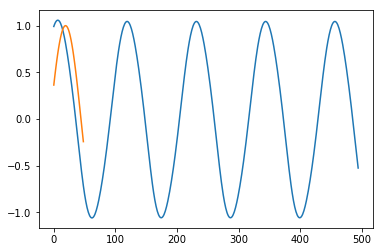

In [240]:
plt.figure() 

plt.plot(predicted) 
plt.plot(X_train[9])


plt.show() 

In [193]:
# sanity check
print 'shapes \n X_train: %r \t y_train: %r \t X_test: %r \t y_test: %r' %(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

shapes 
 X_train: (4456, 49, 1) 	 y_train: (4456,) 	 X_test: (495, 49, 1) 	 y_test: (495,)
